<a href="https://colab.research.google.com/github/AynaAraujo/Machine_Learning-Listas/blob/main/Lista_3_SVM_AYNA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.metrics import f1_score, precision_score, recall_score
from sklearn.decomposition import PCA

## Atividade 1

>**Implemente uma classe que corresponda ao SVM**

Você pode usar uma biblioteca de terceiros para essa finalidade, no entanto, precisará manter os métodos da classe indicada abaixo, que poderá acionar recursos de outra biblioteca para sua solução.

In [ ]:

class SVM:
    def __init__(self, kernel='linear', C=1.0, gamma=None, degree=3, coef0=1, learning_rate=0.001, n_iters=1000):
        self.kernel = kernel # Especifica o tipo de kernel a ser usado ('linear', 'poly', 'rbf').
        self.C = C # Parâmetro de regularização que controla a margem de erro. Um valor maior de C dá menos margem de erro, mas permite menos margem.
        self.gamma = gamma # Coeficiente para kernels 'rbf' e 'poly'.
        self.degree = degree # Grau do polinômio (usado apenas no kernel 'poly').
        self.coef0 = coef0 # Término independente no kernel polinomial e no kernel sigmoid.
        self.learning_rate = learning_rate
        self.n_iters = n_iters
        # Inicializados como None, serão os pesos e o bias do modelo, caso faça sua própria implementação
        self.w = None
        self.b = None

    def _kernel(self, x1, x2):
        if self.kernel == 'linear':
            # Calcule o kernel linear
            return np.dot(x1,x2)
        elif self.kernel == 'poly':
            # Calcule o kernel polinomial
            return (self.gamma*np.dot(x1,x2) + self.coef0)**self.degree
        elif self.kernel == 'rbf':
            # Calcule o kernel gaussiano
            dist = np.linalg.norm(x1-x2)**2
            return np.exp(-self.gamma*dist)
        else:
            raise ValueError("Kernel não reconhecido")

    def fit(self, X, y):
        # Implemente um método que treine o modelo SVM

        n_samples, n_features = X.shape

        # Garantindo que os rótulos sejam 1 ou -1
        y_ = np.where(y <= 0, -1, 1)

        # Continuação do seu código ...
        #KERNEL LINEAR :)
        if self.kernel == 'linear':
          #Definindo pesos:
          self.w = np.zeros(n_features)
          self.b = 0 #sem viés por enquanto

          #Ajustando valores de X: (y*(x*w -b)>=  1)
          for _ in range(self.n_iters):
            for idx,x_i in enumerate(X):
              condition = y_[idx]*np.dot(x_i,self.w) - self.b >= 1
              if condition is True:
                self.w = self.w - (self.learning_rate*2*self.C*self.w)
                self.b = self.b
              else:
                self.w = self.w - self.learning_rate*(2*self.C*self.w - np.dot(y_[idx],x_i))
                self.b = self.b - (self.learning_rate*y_[idx])
        #KERNEL NÃO LINEAR :(
        else:
          #Definindo pesos:
          if self.gamma is None:
               self.gamma = 1 / X.shape[1]
          self.alpha = np.zeros(n_samples)#definindo o coeficiente alpha
          self.b = 0 #sem viés por enquanto
          #Ajustando os valores de X
          for _ in range(self.n_iters):
            for i in range(n_samples):
              s = 0
              for j in range(n_samples):
                s = s + self.alpha[j]*y_[j]*self._kernel(X[j],X[i])
              condition = y_[i]*(s + self.b) >= 1
              if not condition:
                self.alpha[i] = self.alpha[i] + self.learning_rate
                self.b = self.b + self.learning_rate*y_[i]

          sv = self.alpha > 1e-5
          self.alpha_sv = self.alpha[sv]
          self.X_sv = X[sv]
          self.y_sv = y_[sv]





    def project(self, X):
        # Implemente uma função que calcule o valor projetado para as amostras fornecidas.

        # Parâmetros:
        #   X: Matriz de características das amostras.
        # Retorna: Valores projetados.
        # Descrição:
        #   Para o kernel linear, calcula diretamente o produto escalar das amostras com os pesos w, adicionando o bias b.
        #   Para kernels não lineares, calcula a soma ponderada dos kernels entre as amostras e os vetores de suporte.

        # Continuação do seu código ...
        proj = []
        if self.kernel == 'linear':#x*w - b = 0
            proj = np.dot(X,self.w) - self.b
            return proj
        else:
            for x in X:
              s = 0
              for alpha,y_sv, x_sv in zip(self.alpha_sv, self.y_sv,self.X_sv):
                s = s+ alpha*y_sv* self._kernel(x_sv,x)
              proj.append(s + self.b)
            return np.array(proj)


    def predict(self, X):
        return np.sign(self.project(X))

    def evaluate(self, X_test, y_test):
        # Avalia o modelo SVM com os dados de teste fornecidos.
        y_pred = self.predict(X_test)
        accuracy = np.mean(y_pred == y_test)
        return accuracy


In [ ]:
#Função para ver o Hiperplano de decisão COM KERNEL LINEAR
def plot_hyperplane(svm,X,y):
  def get_hyperplane_value(x,w,b,offset):
    #r+ = ( w ⋅ x + b ) / ||w||
    #r- = -( w ⋅ x + b ) / ||w||
    return (-w[0]*x + b + offset)/w[1]

  fig = plt.figure()
  ax = fig.add_subplot(1,1,1)

  plt.scatter(X[:,0],X[:,1],c = y,cmap = 'managua')
  #pegando menor e maior X
  x0_1 = np.amin(X[:, 0])
  x0_2 = np.amax(X[:, 0])

  #Calculando X mais proximos e mais longes relativos aos "lados" positivo,negativos e neutro
  x1_1 = get_hyperplane_value(x0_1, svm.w, svm.b, 0)
  x1_2 = get_hyperplane_value(x0_2, svm.w, svm.b, 0)

  x1_1_m = get_hyperplane_value(x0_1, svm.w, svm.b, -1)
  x1_2_m = get_hyperplane_value(x0_2, svm.w, svm.b, -1)

  x1_1_p = get_hyperplane_value(x0_1, svm.w, svm.b, 1)
  x1_2_p = get_hyperplane_value(x0_2, svm.w, svm.b, 1)

  #Plotando fronteiras de decisão
  ax.plot([x0_1, x0_2], [x1_1, x1_2], 'k')
  ax.plot([x0_1, x0_2], [x1_1_m, x1_2_m], 'k--')
  ax.plot([x0_1, x0_2], [x1_1_p, x1_2_p], 'k--')

  plt.title("Hiperplano de decisão")
  plt.show()




In [ ]:
#para KERNEL NÃO LINEARES
def plot_decision_boundary(model, X, y, resolution=100):
    from matplotlib.colors import ListedColormap
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, resolution),
                         np.linspace(y_min, y_max, resolution))

    # Prever a saída para todos os pontos da grade
    grid = np.c_[xx.ravel(), yy.ravel()]
    Z = model.predict(grid)
    Z = Z.reshape(xx.shape)

    # Plotar
    plt.contourf(xx, yy, Z, cmap=ListedColormap(['#FFAAAA', '#AAAAFF', '#AAFFAA']), alpha=0.5)
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap='bwr', edgecolors='k')
    plt.title(f"Decisão SVM ({model.kernel} kernel)")
    plt.xlabel('X1')
    plt.ylabel('X2')
    plt.show()

###Exemplo de Teste

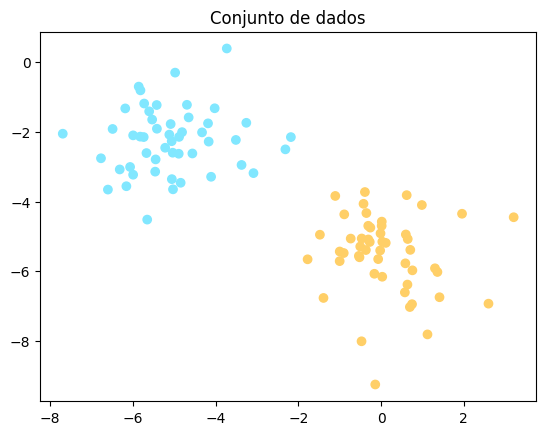

Acurácia no treino: 1.0


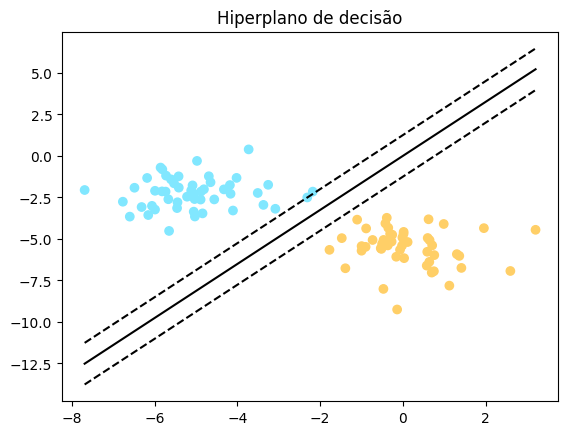

In [ ]:
from sklearn.datasets import make_blobs
#Parametros
n_samples=100
centers=2
random_state=50

X, y = make_blobs(n_samples=n_samples, centers=centers, random_state=random_state)
y = np.where(y == 0, -1, 1)

#Plotando dados
plt.scatter(X[:, 0], X[:, 1], c=y, cmap='managua')
plt.title("Conjunto de dados")
plt.show()


svm = SVM(kernel='linear', C=1.0, learning_rate=0.001, n_iters=1000)
svm.fit(X, y)

acc = svm.evaluate(X, y)
print("Acurácia no treino:", acc)

plot_hyperplane(svm, X, y)

## **Atividade 2 - Classificação com o dataset Iris**

Features: Total de 4

Para essa atividade utilizar as features:
1. Comprimento do sépalo (sepal length)
2. Largura do sépalo (sepal width)
3. Comprimento da pétala (petal length)
4. Largura da pétala (petal width)

Variável dependente: Espécie da flor Iris (Setosa, Versicolor ou Virginica)


>**Treine os dados da base Iris utilizando SVM implementado**

>**Faça as predições nos dados de teste e compare os dados reais com os preditos**

In [ ]:
# Carregando o conjunto de dados Iris
data = load_iris()
colunas = ['sepal length', 'sepal width', 'petal length', 'petal width']
pd.DataFrame(data['data'], columns=colunas)

,sepal length,sepal width,petal length,petal width
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2
...,...,...,...,...
145,6.7,3.0,5.2,2.3
146,6.3,2.5,5.0,1.9
147,6.5,3.0,5.2,2.0
148,6.2,3.4,5.4,2.3


In [ ]:
targets = np.array(data.target_names)
print(targets)

['setosa' 'versicolor' 'virginica']


In [ ]:
#Separando dados entre teste e treino:
from sklearn.model_selection import train_test_split

#Parametros
random_state=50
test_size = 0.3

data = load_iris()
X, y = data.data, data.target

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=test_size,random_state = random_state)


##Antes de Normalizar

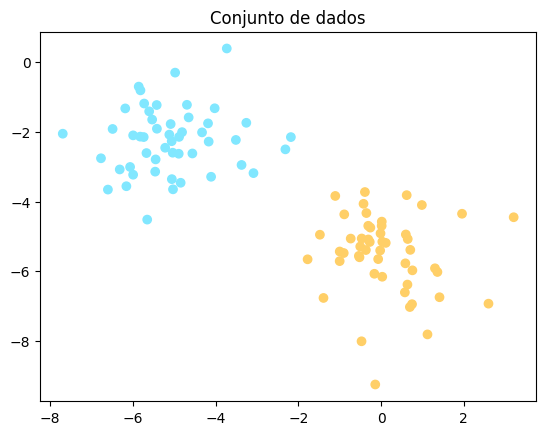

Acurácia no treino: 0.39473684210526316


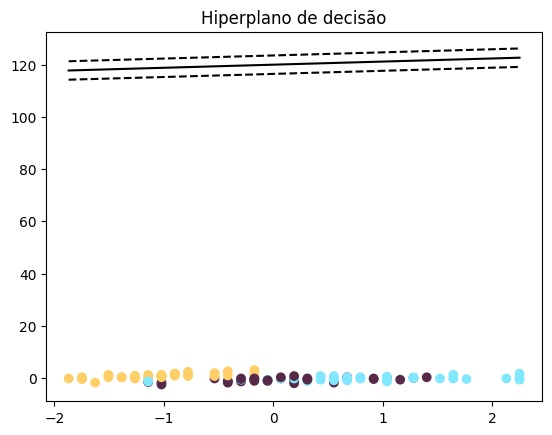

In [ ]:
#Plotando dados
plt.scatter(X[:, 0], X[:, 1], c=y, cmap='managua')
plt.title("Conjunto de dados")
plt.show()


svm = SVM(kernel='linear', C=1.0, learning_rate=0.001, n_iters=1000)
svm.fit(X_train, y_train)

acc = svm.evaluate(X_test, y_test)
print("Acurácia no treino:", acc)

plot_hyperplane(svm, X_train, y_train)

>**Normalize os dados da base Iris e refaça o treinamento do modelo**

Compare os resultados dos dados normalizados e não normalizados. Como métricas de avaliação podem utilizar recall, precision e f-measure.

##Depois de Normalizar

In [ ]:
from sklearn.preprocessing import StandardScaler
#Functions to scale
def scaler_Min_Max(X):
  X = np.array(X)
  #Get de min and max values
  X_min,X_max = X.min(axis=0), X.max(axis=0)
  #Gets the scale
  X_scaled = (X -X_min)/(X_max - X_min)

  return X_scaled

def scaler_Z_score(X):
  scaler = StandardScaler()
  X_scaled = scaler.fit_transform(X)
  return np.array(X_scaled)

In [ ]:
#Separando dados entre teste e treino:
from sklearn.model_selection import train_test_split

def scaler_data(X,y,scaler,random_state,train_size,test_size):
  if scaler == 'Z_score':
    X_scaled = scaler_Z_score(X)
  elif  scaler == 'Min_Max':
    X_scaled = scaler_Min_Max(X)
  else:
    raise Exception('Scaler inválido')

  X_train, X_temp, y_train, y_temp = train_test_split(X_scaled,y,test_size= train_size,random_state = random_state)
  if train_size != None:
    X_val, X_test,y_val, y_test = train_test_split(X_temp,y_temp,test_size=test_size,random_state= random_state)
    return  X_train, X_test,  X_val,y_train, y_test,y_val

  return X_train, X_temp, y_train, y_temp

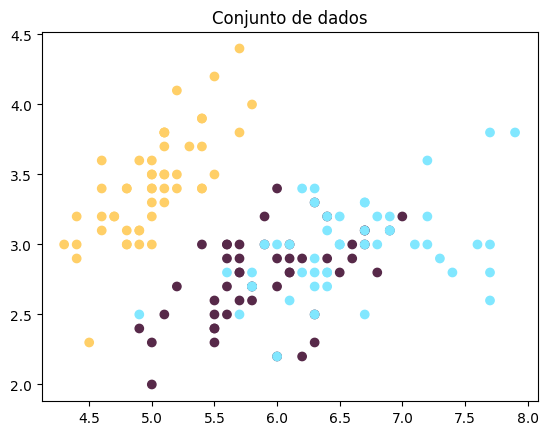

Acurácia no treino: 0.39473684210526316


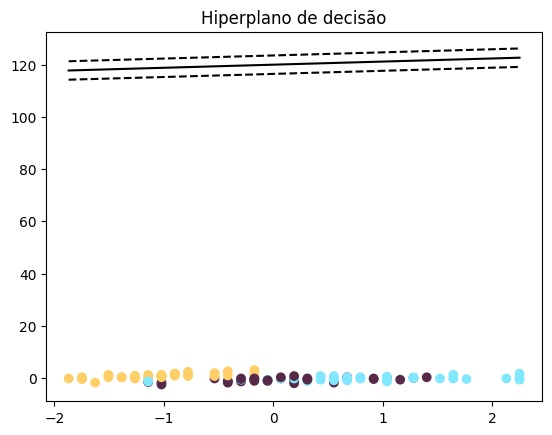

In [ ]:
#Parametros
random_state=50
train_size =None
test_size = 0.3
scaler = 'Z_score'

data = load_iris()
X, y = data.data, data.target
X_train, X_test, y_train, y_test = scaler_data(X, y,scaler,random_state,train_size,test_size)

#Plotando dados
plt.scatter(X[:, 0], X[:, 1], c=y, cmap='managua')
plt.title("Conjunto de dados")
plt.show()


svm = SVM(kernel='linear', C=1.0, learning_rate=0.001, n_iters=1000)
svm.fit(X_train, y_train)

acc = svm.evaluate(X_test, y_test)
print("Acurácia no treino:", acc)

plot_hyperplane(svm, X_train, y_train)

###Com Kernel não linear

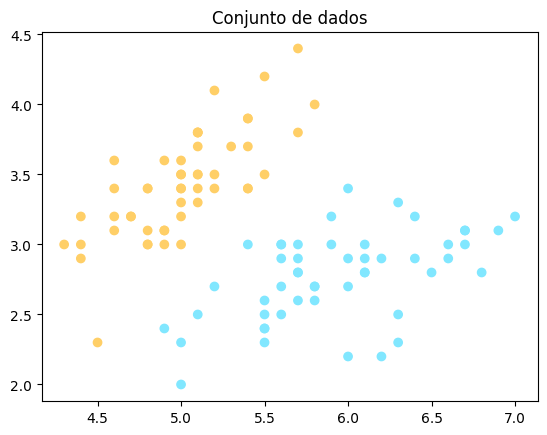

Acurácia no treino: 0.39473684210526316


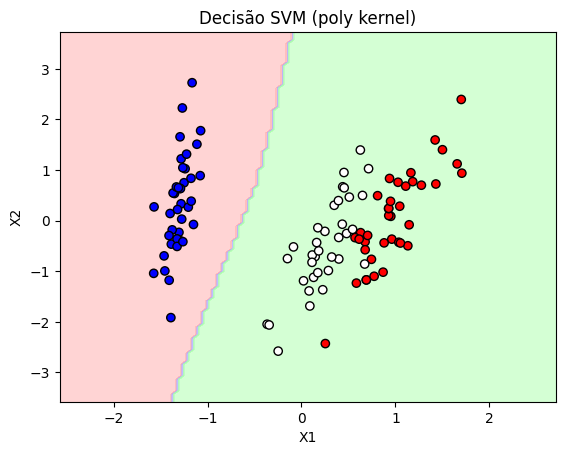

In [ ]:
from sklearn.decomposition import PCA
#Parametros para os dados
random_state=50
train_size =None
test_size = 0.3
scaler = 'Z_score'
#svm
kernel = 'poly'
C = 1.0
learning_rate = 0.001
n_iters = 1000


data = load_iris()
X, y = data.data, data.target

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

X_train, X_test, y_train, y_test = scaler_data(X_pca, y,scaler,random_state,train_size,test_size)
X = X[y != 2]
y = y[y != 2]


#Plotando dados
plt.scatter(X[:, 0], X[:, 1], c=y, cmap='managua')
plt.title("Conjunto de dados")
plt.show()


svm = SVM(kernel=kernel, C=C, learning_rate=learning_rate, n_iters=n_iters)
svm.fit(X_train, y_train)

acc = svm.evaluate(X_test, y_test)
print("Acurácia no treino:", acc)

plot_decision_boundary(svm, X_train, y_train)

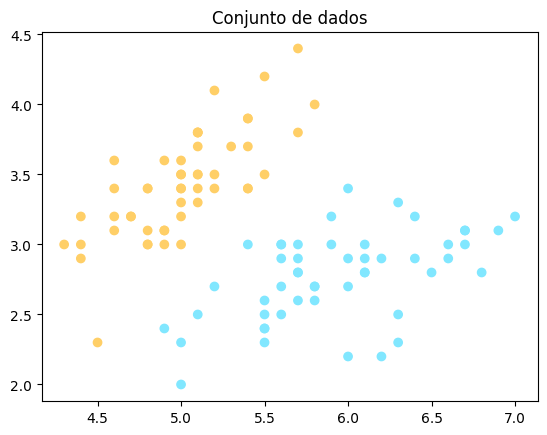

Acurácia no treino: 0.39473684210526316


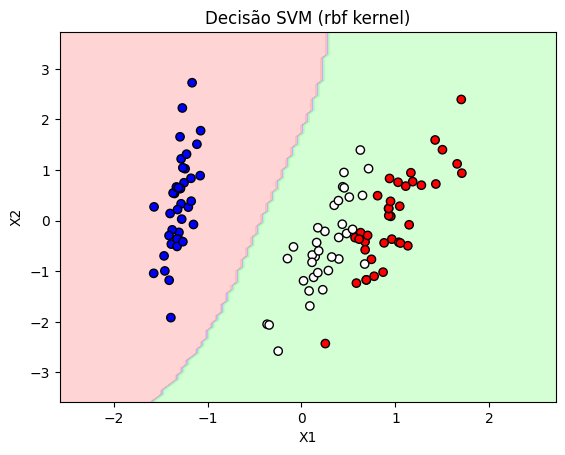

In [ ]:
from sklearn.decomposition import PCA
#Parametros para os dados
random_state=50
train_size =None
test_size = 0.3
scaler = 'Z_score'
#svm
kernel = 'rbf'
C = 1.0
learning_rate = 0.001
n_iters = 1000


data = load_iris()
X, y = data.data, data.target

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

X_train, X_test, y_train, y_test = scaler_data(X_pca, y,scaler,random_state,train_size,test_size)
X = X[y != 2]
y = y[y != 2]


#Plotando dados
plt.scatter(X[:, 0], X[:, 1], c=y, cmap='managua')
plt.title("Conjunto de dados")
plt.show()


svm = SVM(kernel=kernel, C=C, learning_rate=learning_rate, n_iters=n_iters)
svm.fit(X_train, y_train)

acc = svm.evaluate(X_test, y_test)
print("Acurácia no treino:", acc)

plot_decision_boundary(svm, X_train, y_train)

Como esse problema envolve 3 classes podemos ver pelos testes anteriores que é necessário ajustar a classe SVM para ser multiclasse

##SVM MULTICLASSE:

In [ ]:
class SVM_OVR(SVM):
    def __init__(self, kernel='linear', C=1.0, gamma=None, degree=3, coef0=1, learning_rate=0.001, n_iters=1000):
        super().__init__(kernel=kernel, C=C, gamma=gamma, degree=degree, coef0=coef0,
                         learning_rate=learning_rate, n_iters=n_iters)
        self.models = []

    def fit(self, X, y):
        self.classes = np.unique(y)
        self.models = []

        for cls in self.classes:
            y_binary = np.where(y == cls, 1, -1)
            clf = SVM(kernel=self.kernel, C=self.C, gamma=self.gamma,
                      degree=self.degree, coef0=self.coef0,
                      learning_rate=self.learning_rate, n_iters=self.n_iters)
            clf.fit(X, y_binary)
            self.models.append(clf)

    def predict(self, X):
        # Pega o valor da função de decisão de cada classificador
        decisions = np.array([model.project(X) for model in self.models])
        # Índice da maior pontuação -> classe predita
        best = np.argmax(decisions, axis=0)
        return self.classes[best]

    def evaluate(self, X_test, y_test):
        y_pred = self.predict(X_test)
        return np.mean(y_pred == y_test)


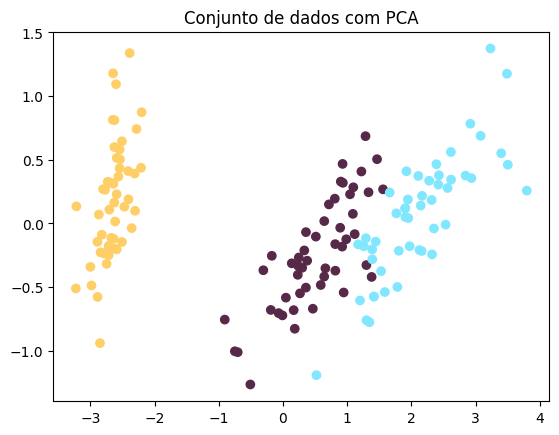

Acurácia no teste: 0.9210526315789473


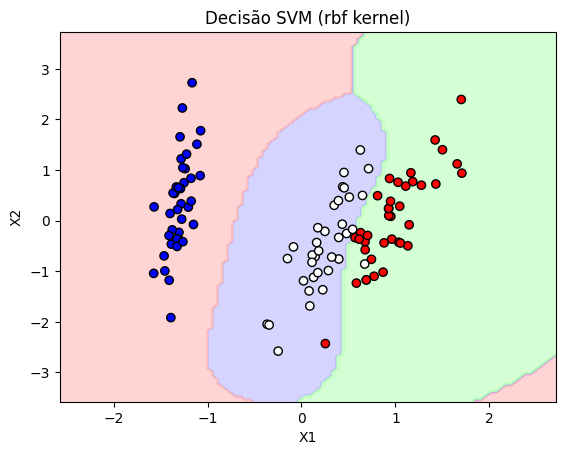

In [ ]:
# Parâmetros para os dados
random_state = 50
train_size = None
test_size = 0.3
scaler = 'Z_score'

# SVM
kernel = 'rbf'
C = 1.0
learning_rate = 0.001
n_iters = 1000

# Carregar os dados
data = load_iris()
X, y = data.data, data.target

# Reduzindo para 2D com PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

# Separando em treino e teste
X_train, X_test, y_train, y_test = scaler_data(X_pca, y, scaler, random_state, train_size, test_size)

# Plotando dados
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap='managua')
plt.title("Conjunto de dados com PCA")
plt.show()

# Treinando SVM_OVR
svm = SVM_OVR(kernel=kernel, C=C, learning_rate=learning_rate, n_iters=n_iters)
svm.fit(X_train, y_train)


acc = svm.evaluate(X_test, y_test)
print("Acurácia no teste:", acc)

# Plotando a fronteira de decisão
plot_decision_boundary(svm, X_train, y_train)


>**Divida o dataset em treinamento, teste e validação. Escreva um código que escolhe os melhores hiperparâmetros ajustando o conjunto de validação.**

Por exemplo qual o melhor Kernel vizinho (linear, poly, rbf), qual a melhor C, gamma. Como métricas de avaliação podem utilizar recall, precision e f-measure.

In [ ]:
#Parametros vars: Kernel, C e gamma
#Métricas: recall, precision e f-measure

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/m


Treinando com os melhores parâmetros em dados de treino+validação...
Acurácia no teste final: 1.0


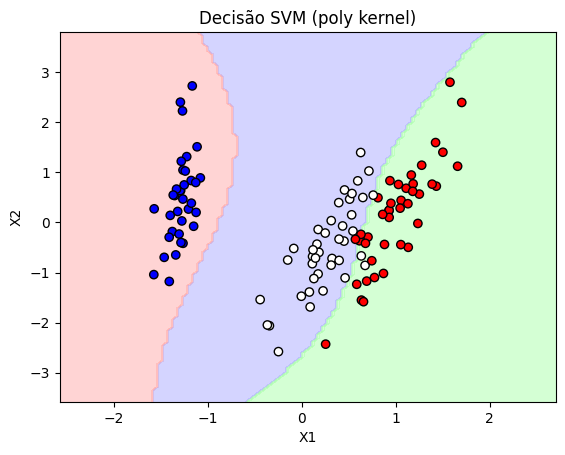


Melhores parâmetros encontrados:
- Kernel: poly
- C: 1
- F1-Score (Validação): 0.9063
- Precision: 0.9102
- Recall: 0.9067


In [ ]:
# Parâmetros para os dados
random_state = 50
train_size = 0.7
test_size = 0.3
scaler = 'Z_score'

# SVM
learning_rate = 0.001
n_iters = 1000
kernel_list  = ['linear','poly','rbf']
C_range = range(1,5)

#Lista para métricas:
kernels = []
Cs = []
metrics = []
scores = []
best_params = {"f1_score": 0,"precision":0 ,"recall":0,"kernel": None, "C": None}

# Carregar os dados
data = load_iris()
X, y = data.data, data.target

# Reduzindo para 2D com PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

# Separando em treino e teste
X_train, X_test, X_val, y_train, y_test, y_val = scaler_data(X_pca, y, scaler, random_state, train_size, test_size)

for kernel in kernel_list:
    for C in C_range:
        model = SVM_OVR(kernel=kernel, C=C, learning_rate=learning_rate, n_iters=n_iters)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_val)

        precision = precision_score(y_val, y_pred, average='macro')
        recall = recall_score(y_val, y_pred, average='macro')
        f1 = f1_score(y_val, y_pred, average='macro')

        for metric_name, metric_value in zip(['Precision', 'Recall', 'F1-Score'], [precision, recall, f1]):
            kernels.append(kernel)
            Cs.append(C)
            metrics.append(metric_name)
            scores.append(metric_value)

        if f1 > best_params["f1_score"]:
            best_params.update({
                "f1_score": f1,
                "precision": precision,
                "recall": recall,
                "kernel": kernel,
                "C": C
            })

# Criar dataframe
df = pd.DataFrame({
    'Kernel': kernels,
    'C': Cs,
    'Score': scores,
    'Metric': metrics
})

# Plotly interativo
fig = px.line(df, x='C', y='Score', color='Metric', markers=True,
              title='Precision, Recall e F1-Score vs C (Validação)',
              labels={'C': 'C (Parâmetro da SVM)', 'Score': 'Métrica'},
              hover_name='Metric',
              facet_col="Kernel")
fig.show()

# Treinar com melhores parâmetros usando treino + validação
X_final_train = np.vstack((X_train, X_val))
y_final_train = np.concatenate((y_train, y_val))

print("\nTreinando com os melhores parâmetros em dados de treino+validação...")
best_model = SVM_OVR(kernel=best_params["kernel"], C=best_params["C"],
                     learning_rate=learning_rate, n_iters=n_iters)
best_model.fit(X_final_train, y_final_train)
acc = best_model.evaluate(X_test, y_test)
print("Acurácia no teste final:", acc)

# Plotar fronteira
plot_decision_boundary(best_model, X_final_train, y_final_train)

# Exibir melhores parâmetros
print("\nMelhores parâmetros encontrados:")
print(f"- Kernel: {best_params['kernel']}")
print(f"- C: {best_params['C']}")
print(f"- F1-Score (Validação): {best_params['f1_score']:.4f}")
print(f"- Precision: {best_params['precision']:.4f}")
print(f"- Recall: {best_params['recall']:.4f}")

Podemos ver que no fim o que mais influênciou no treino foi o tipo de kernel